# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from joblib import dump

In [2]:
data = pd.read_csv('/workspaces/Data-Science/Dataset/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.isna().sum() 

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


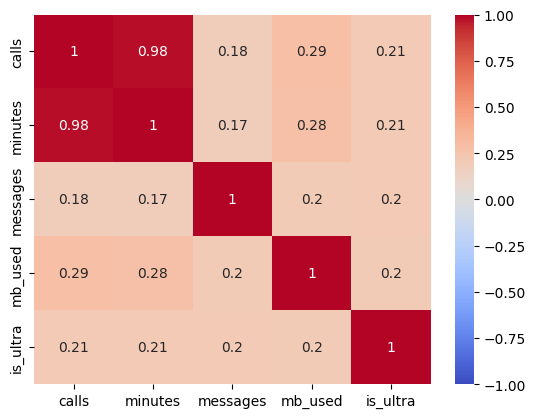

In [7]:
sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

**Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:**
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Разбейте данные на выборки

In [8]:
# отделим 20% данных для тестовой выборки (для проверки модели)
data_other, data_test = train_test_split(data, test_size=0.2, random_state=12345)


In [9]:
features_other = data_other.drop(['is_ultra'], axis=1) 
target_other = data_other['is_ultra']
features_test = data_test.drop(['is_ultra'], axis=1) 
target_test = data_test['is_ultra']

In [10]:
# отделим 25% данных для validation выборки 
data_train, data_valid = train_test_split(data_other, test_size=0.25, random_state=12345) # < разделите данные на обучающую и валидационную выборки >

In [11]:
features_train = data_train.drop(['is_ultra'], axis=1) 
target_train = data_train['is_ultra']
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

In [12]:
print('Размер обучающей выборки', len(data_train))
print('Размер валидационной выборки', len(data_valid))
print('Размер тестовой выборки', len(data_test))

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


In [13]:
len(data) - (len(data_train) + len(data_valid) + len(data_test))

0

In [14]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [1339  589]
Количество строк в target_test по классам: [447 196]


In [15]:
def prop (data, column, set_name):
    result = round((data[column].sum()/len(data[column])*100), 2)
    return print(f'Доля в % абонентов «Ультра» в выборке {set_name}:',result)

In [16]:
prop(data_train,'is_ultra', '"Тренировочный набор"')
prop(data_valid,'is_ultra', '"Валидационный набор"')
prop(data_test,'is_ultra', '"Тестовый набор"')
prop(data,'is_ultra', '"Исходный набор"')

Доля в % абонентов «Ультра» в выборке "Тренировочный набор": 30.55
Доля в % абонентов «Ультра» в выборке "Валидационный набор": 31.1
Доля в % абонентов «Ультра» в выборке "Тестовый набор": 30.48
Доля в % абонентов «Ультра» в выборке "Исходный набор": 30.65


In [17]:
(data['is_ultra'].value_counts()/data.shape[0]).to_frame()

,is_ultra
0,0.693528
1,0.306472


 Использовал классические пропорции 80-20-20. Проверили контроль разбиения использовав .shape. В начальной модели у нас 30.6 % пользователей Ультра. Сравним потом с итоговыми  (train/valid/test)

## Исследуйте модели

### Модель случайный лес

#### Этап 1. Оптимизация гиперпараметров. RandomizedSearchCV
Начать можно с алгоритма RandomizedSearchCV, который позволяет довольно грубо исследовать широкие диапазоны значений

In [18]:
%%time
1 + 1
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
#В ходе работы мы генерируем сущность param_dist, содержащую, для каждого гиперпараметра, диапазон значений, которые нужно испытать
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345)
model.fit(features_train, target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 1.01 s, sys: 108 ms, total: 1.12 s
Wall time: 2min 25s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n_estimators': [1, 53, 106, 158, 211,
                                                         263, 316, 369, 421,
                                                         474, 526, 579, 631,
                                                         684, 737, 789, 842,
                                                         894, 947, 1000]},
                   random_state=12345, verbose=1)

* При значениях параметров n_iter = 100 и cv = 3, мы создали 300 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров
* Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, мы легко можем получить датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.

In [19]:
rs_df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,106,34,7,sqrt,19,True,0.820029,1
1,421,39,7,log2,18,True,0.818472,2
2,842,34,7,sqrt,10,True,0.818470,3
3,526,23,2,log2,19,True,0.818468,4
4,158,44,7,log2,11,False,0.817954,5
...,...,...,...,...,...,...,...,...
95,789,44,18,sqrt,1,False,0.774903,96
96,579,39,2,sqrt,1,False,0.774903,96
97,579,28,39,sqrt,1,True,0.772307,98
98,631,7,44,log2,1,True,0.769200,99


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

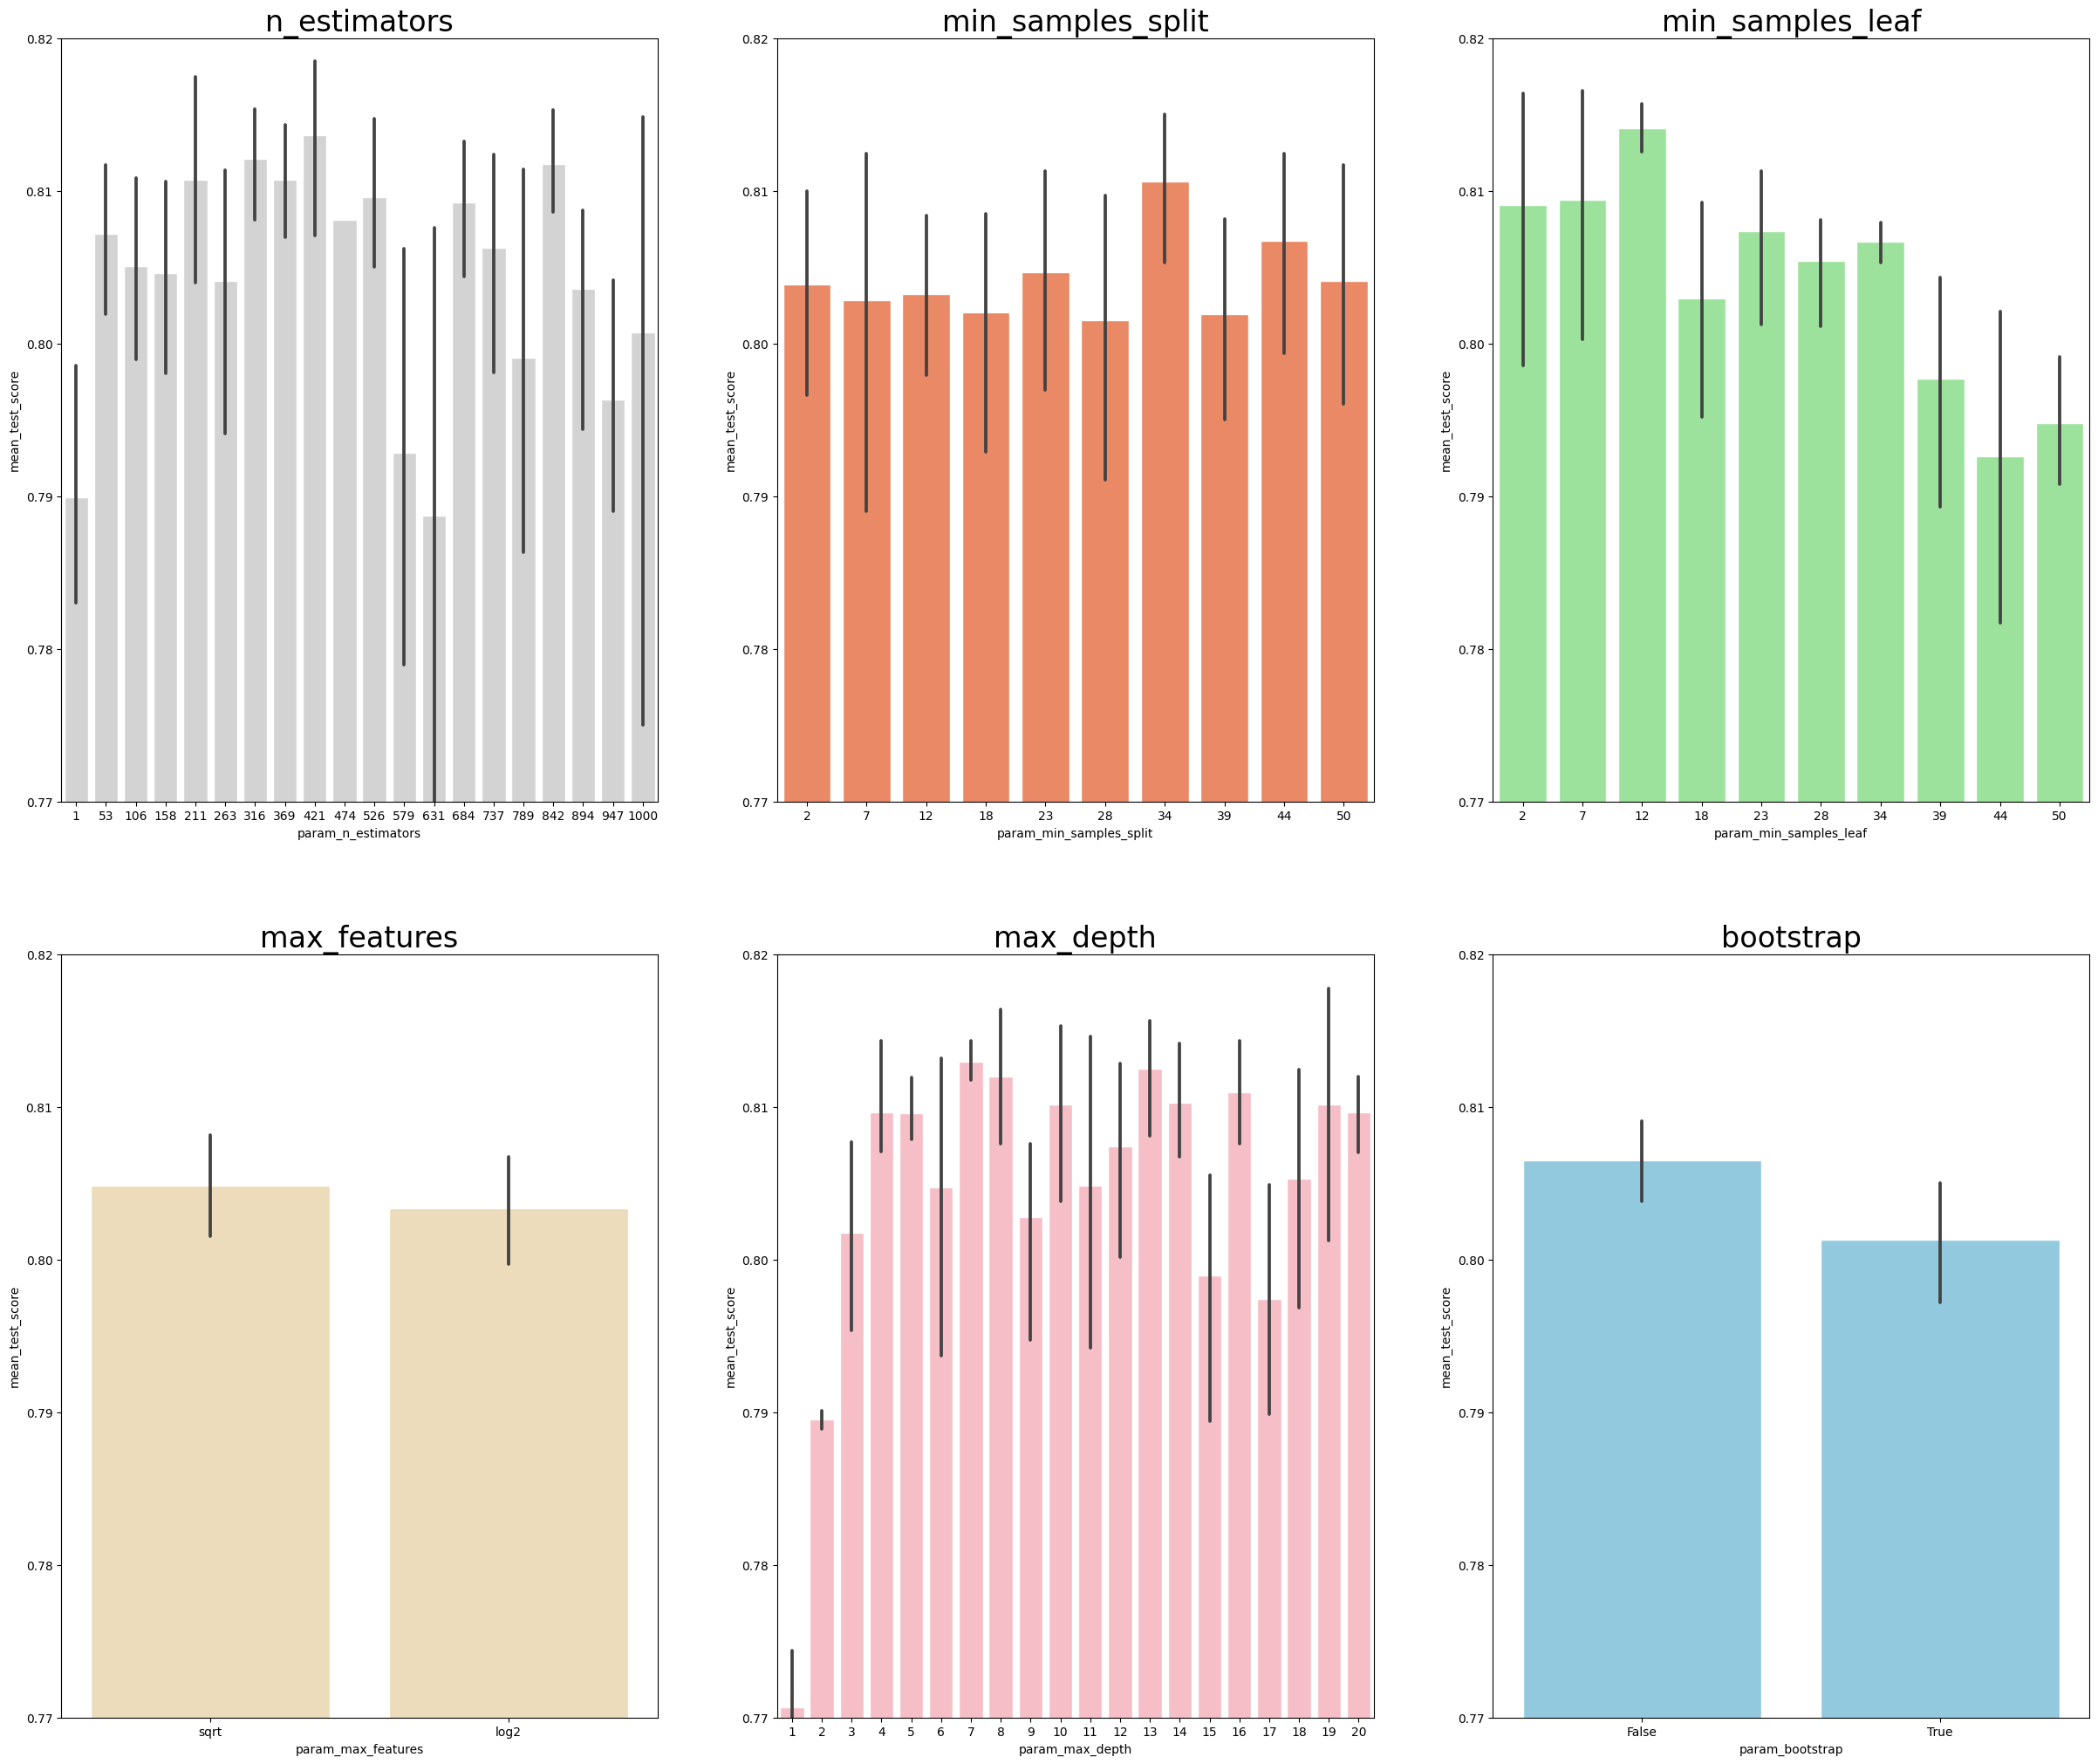

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.77,.82])
axs[0,0].set_title('n_estimators')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.77,.82])
axs[0,1].set_title('min_samples_split')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.77,.82])
axs[0,2].set_title('min_samples_leaf')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.77,.82])
axs[1,0].set_title('max_features')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.77,.82])
axs[1,1].set_title('max_depth')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.77,.82])
axs[1,2].set_title('bootstrap')

plt.show()

Анализируя графики можно увидеть некоторые закономеренности:
1. n_estimators - выберем лучшие параметры 316, 421, 842
2. min_samples_split - выберем лучшие параметры 23, 34, 44
3. min_samples_leaf - выберем лучшие параметры 2, 7, 12
4. max_features -  вариант sqrt и log2 даёт одинаковый результат.
5. max_depth - выберем лучшие параметры 4,5,7, 13
6. bootstrap - вариант False даёт самый высокий средний результат.

#### Этап 2. Оптимизация гиперпараметров. GridSearchCV

In [21]:
%%time
1 + 1
n_estimators = [316, 421, 842]
max_features = ['sqrt', 'log2']
max_depth = [4,5,7, 13]
min_samples_split = [23, 34, 44]
min_samples_leaf = [2, 7, 12]
bootstrap = [False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model = GridSearchCV(RandomForestClassifier(), 
                     param_dist, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs=-1)
model.fit(features_other, target_other)
model.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
CPU times: user 3.06 s, sys: 163 ms, total: 3.23 s
Wall time: 7min 3s


RandomForestClassifier(bootstrap=False, max_depth=13, min_samples_leaf=7,
                       min_samples_split=44, n_estimators=316)

In [22]:
model.best_score_

0.8082458187475691

Здесь мы применяем кросс-валидацию по 3 блокам для 216 (3 x 2 x 4 x 3 x 3 x 1) сеансов обучения модели, что даёт 648 сеансов обучения модели, случайно выбирая комбинации представленных выше гиперпараметров. Мы можем обратиться к атрибуту best_params_ для получения сведений о наборе параметров, позволяющем создать самую лучшую модель.

#### **Вывод:** 
*Наилучшие гиперпараметры для модели случайный лес при Accuracy = 0.8094126798910929:*
* 'n_estimators': 316
* 'min_samples_split': 44
* 'min_samples_leaf': 2
* 'max_features': 'log2'
* 'max_depth': 5
* 'bootstrap': False

### Модель Логистическая регрессия
* С помощью смены гиперпараметров подберем самые подходящие. С самым большим показателем Accuracy

In [23]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6967340590979783

In [24]:
model = LogisticRegression(solver = 'saga', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.6936236391912908

In [25]:
model = LogisticRegression(solver = 'lbfgs', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6920684292379471

In [26]:
model = LogisticRegression(solver = 'lbfgs', penalty = 'l2', multi_class ='auto', fit_intercept=False, dual=False, C=2,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6967340590979783

**Вывод:** 
*Наилучшие гиперпараметры для модели логистическая регрессия, полученное методом перебора с Accuracy 0.6998444790046656:*
* olver = 'lbfgs', 
* penalty = 'l2', 
* multi_class ='auto', 
* fit_intercept=True, 
* dual=False, 
* C=10,
* random_state=12345, 
* max_iter=1000

### Модель Дерево решений

In [27]:
best_model = None
best_result = 0
for depth in range(1, 6):
	model = DecisionTreeClassifier(max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_train, target_train) # обучим модель
	predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = accuracy_score(target_valid, predictions) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("Accuracy лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

Accuracy лучшей модели: 0.7651632970451011
max_depth лучшей модели: DecisionTreeClassifier(max_depth=3)


**Вывод:** 
*Наилучшие гиперпараметры для древа решений, полученное методом перебора с Accuracy 0.7651632970451011:*
* max_depth=3, 

### Общий вывод по выбору модели
*Наилучшие гиперпараметры для модели случайный лес при Accuracy = 0.8094126798910929:*
* 'n_estimators': 316
* 'min_samples_split': 44
* 'min_samples_leaf': 2
* 'max_features': 'log2'
* 'max_depth': 5
* 'bootstrap': False

## Проверьте модель на тестовой выборке

In [28]:
model = RandomForestClassifier(n_estimators = 316, min_samples_split = 44, min_samples_leaf = 2, 
                               max_features ='log2', max_depth = 5, bootstrap = False, n_jobs=-1,
                               verbose = 1) # обучите модель с заданным гиперпараметрами
model_RFC_final_prediction = model.fit(features_test, target_test)
predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
result = accuracy_score(target_valid, predictions) # посчитайте качество модели на валидационной выборке

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


In [29]:
print("Accuracy лучшей модели:", result)

Accuracy лучшей модели: 0.7698289269051322


## (бонус) Проверьте модели на адекватность

Проверим модели на вменяемость. Для это построим случайную модель на основе DummyClassifier, попробуем посмотреть количественные характеристики по выборке столбца is_ultra

In [30]:
strategies = ['most_frequent', 'stratified', 'uniform']
dummies_result = []
for strat in strategies:
    dc = DummyClassifier(strategy=strat, random_state=42)
    dc.fit(features_train, target_train)
    res = dc.score(features_test, target_test)
    dummies_result.append({strat:res})

pd.DataFrame(dummies_result).fillna(0)

,most_frequent,stratified,uniform
0,0.695179,0.000000,0.000000
1,0.000000,0.589425,0.000000
2,0.000000,0.000000,0.496112


Самый лучший вариант, что мы получили алгоритмом - 0.695, в то время как наши модели показывают правильность больше 0.7744945567651633.

Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

In [31]:
(data['is_ultra'].value_counts()/data.shape[0]).to_frame()

,is_ultra
0,0.693528
1,0.306472


Доля клиентов с тарифом "Ультра" в начальной выборке 69,35 %. Наши модели показывают большую точность, они выявили закономерности, позволяющие предложить новым пользователям тариф